In [62]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

import os
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

CSV_DIR = 'csv_merged'

In [63]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [64]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        fillna = lambda v: 0.0 if v == 'nan' else v
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        remerged_batch = []
        pos = -1
        try:
            dataf.loc[i] = [np.trapz([fillna(row[j][p]) for j in row]) for p in range(batch)]
        except:
            last_row = yaml.safe_load(df.iloc[-1].iloc[0])
            remerged_batch = [np.trapz([fillna(row[j][p]) for j in row]) for p in range(8)] + [np.trapz([fillna(last_row[j][p]) for j in row]) for p in range(8)]
            if pos == -1:
                pos = i
        if remerged_batch:
            dataf.loc[pos] = remerged_batch
            dataf = dataf[:-1]
    return dataf

In [65]:
metrics =  [
    'Model Parameter Randomisation',
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity'    
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x.fillna(x.mean()),
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x.fillna(x.mean()),
    'Faithfulness Correlation': lambda x: x.fillna(x.mean()),
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x.fillna(x.mean()),
    'Sparseness': lambda x: x.fillna(x.mean()),
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x.fillna(x.mean()),
    'Selectivity': lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

aggregate = {
    'Monotonicity Nguyen': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Local Lipschitz Estimate': np.mean,
    'Faithfulness Estimate': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Faithfulness Correlation': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Avg-Sensitivity': np.mean,
    'Random Logit': np.mean,
    'Max-Sensitivity': np.mean,
    'Sparseness': np.mean, 
    'EffectiveComplexity': np.mean,
    'Monotonicity Arya': np.mean,
    'Complexity': np.mean,
    'Pixel-Flipping': np.mean,
    'Selectivity': np.mean,
    'Model Parameter Randomisation': np.mean
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', 'gaussian', 'polycam',
           'cameras']#, 'extremal_perturbation']

models = ['resnet50']
datasets = ['cifar10']

dico_ranks = {}

In [66]:
for dataset in datasets:
    print(f'DATASET {dataset.upper()}')
    dico_ranks[dataset] = {}
    for model in models:
        print(f'MODEL {model.upper()}')
        dico_ranks[dataset][model] = {}
        for metr in metrics:
            if metr in metrics_with_different_baselines and model == 'resnet50' and dataset == 'imagenet':
                for baseline in baselines:
                    metr_with_baseline = f'{metr} with {baseline}'
                    print(f"-- Metric: {metr_with_baseline}")
                    scores = []
                    for meth in methods:
                        if meth == 'cameras' or meth == 'extremal_perturbation':
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                        else:
                            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                        try:
                            df = pd.read_csv(csv_name, header = None)
                            data = transform[metr](df).values.flatten()[:2000]
                            scores.append(-aggregate[metr](data))
                        except:
                            print(     f'error with {csv_name} --> replace by dummy data')
                            scores.append(0.)
                    #dico_ranks[dataset][model][metr_with_baseline] = rankdata(scores)
                    dico_ranks[dataset][model][metr_with_baseline] = scores
            else:
                print(f"-- Metric: {metr}")
                scores = []
                for meth in methods:
                    csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                    try:
                        df = pd.read_csv(csv_name, header = None)
                        data = transform[metr](df).values.flatten()[:2000]
                        scores.append(-aggregate[metr](data))
                    except:
                        print(     f'error with {csv_name} --> replace by dummy data')
                        scores.append(0.)
                #dico_ranks[dataset][model][metr] = rankdata(scores)
                dico_ranks[dataset][model][metr] = scores
        print()
    print()
    print()

DATASET CIFAR10
MODEL RESNET50
-- Metric: Model Parameter Randomisation
-- Metric: Monotonicity Nguyen
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate
-- Metric: Faithfulness Correlation
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Arya
-- Metric: Complexity
-- Metric: Pixel-Flipping
-- Metric: Selectivity





In [67]:
with open('rankings_by_avg_aggreg_cifar10.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

In [6]:
with open('rankings_by_avg_aggreg_cifar10.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [68]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [69]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [70]:
def plot_corr_matrix_figure(dico_ranks, metrics, y_labels, x_labels, filename, fig_size, rotate_x=True, half_rotate_x=False, rotate_y=True, subgroups=None):
    tau_values, p_values = compute_kendall_tau(dico_ranks, metrics)
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(tau_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='viridis')

    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(tau_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='viridis')

    if half_rotate_x:
        plt.xticks(rotation=20, ha="right")
    elif rotate_x:
        plt.xticks(rotation=0)
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='crimson', lw=4, clip_on=False))
            start_i += subgroup_size
    
    plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')
    plt.show()
    plt.close()
    
    print('RESULTS')
    print(f"Kendall's W: {compute_kendall_w(dico_ranks, metrics)}")
    print("Kendall's Tau:")
    for i, metric_a in enumerate(metrics):
        for j, metric_b in enumerate(metrics):
            if i < j:
                print(f'{metric_a} / {metric_b} : {tau_values[i][j]} ({p_values[i][j]})')

# Figures and results for article

## ResNet50 (Cifar10)

In [71]:
df_ranks = pd.DataFrame(dico_ranks['cifar10']['resnet50'], index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [72]:
df_ranks

,Model Parameter Randomisation,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Random Logit,Max-Sensitivity,Sparseness,EffectiveComplexity,Monotonicity Arya,Complexity,Pixel-Flipping,Selectivity
integratedgrad,-0.075246,-0.165786,3.222661,0.063822,0.015153,0.070988,-0.595798,0.088438,-0.619585,1023.6255,-0.531500,6.211817,5.320233,53.485633
smoothgrad,40.492082,-0.228401,302.316715,-0.259918,-0.060428,0.002510,-0.460772,0.003002,-0.204990,1024.0000,-0.520984,6.860155,7.463230,61.434845
guidedbackprop,49.406528,-0.179798,1.508058,-0.164855,-0.067251,0.005217,-0.822650,0.006210,-0.714701,1019.6730,-0.521694,5.908163,5.541854,55.735517
rise,-4.509271,-0.028975,3.124541,-0.022753,-0.035258,0.056290,0.008255,0.081224,-0.128480,1023.9960,-0.547129,6.873742,7.707400,61.327940
gradcam,-1.367127,-0.043180,5.356011,-0.125164,-0.053674,0.069493,-0.073137,0.115306,-0.360382,950.5920,-0.565274,6.672919,12.768743,84.142987
scorecam,-2.462052,-0.020162,9.814290,-0.056856,-0.008510,0.101619,-0.427981,0.166506,-0.366126,959.9920,-0.568435,6.669936,14.066609,90.562532
layercam,3.063971,0.008575,5.926029,-0.100532,-0.050184,0.048804,-0.406600,0.073191,-0.132012,1024.0000,-0.534081,6.893982,10.841898,69.076132
random,0.004023,-0.002732,1698.157589,-0.000552,-0.000103,0.209859,-1.000000,0.215298,-0.332947,1023.9900,-0.523790,6.738547,4.796112,52.457988
sobel,106.000000,0.001628,0.000141,0.028415,-0.030846,0.106272,-1.000000,0.112900,-0.434532,1020.5770,-0.532177,6.597621,8.535861,61.061865
gaussian,106.000000,-0.256504,-0.000000,-0.250682,-0.057571,-0.000000,-1.000000,-0.000000,-0.122918,1024.0000,-0.494968,6.908152,6.910997,62.019248


### Faithfulness with black baseline and different metrics

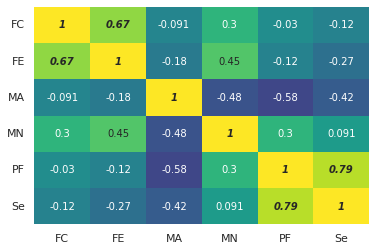

RESULTS
Kendall's W: 0.1686091686091686
Kendall's Tau:
Faithfulness Correlation / Faithfulness Estimate : 0.6666666666666666 (0.0018032758136924804)
Faithfulness Correlation / Monotonicity Arya : -0.0909090909090909 (0.7373055246579552)
Faithfulness Correlation / Monotonicity Nguyen : 0.303030303030303 (0.19694994338223504)
Faithfulness Correlation / Pixel-Flipping : -0.0303030303030303 (0.9465592891547753)
Faithfulness Correlation / Selectivity : -0.1212121212121212 (0.6383612539081289)
Faithfulness Estimate / Monotonicity Arya : -0.1818181818181818 (0.459023957331249)
Faithfulness Estimate / Monotonicity Nguyen : 0.4545454545454545 (0.04473689858238469)
Faithfulness Estimate / Pixel-Flipping : -0.1212121212121212 (0.6383612539081289)
Faithfulness Estimate / Selectivity : -0.2727272727272727 (0.24957952123750735)
Monotonicity Arya / Monotonicity Nguyen : -0.4848484848484848 (0.031050242838437284)
Monotonicity Arya / Pixel-Flipping : -0.5757575757575757 (0.008757732750788306)
Monotonic

In [73]:
selected_metrics = ['Faithfulness Correlation','Faithfulness Estimate','Monotonicity Arya','Monotonicity Nguyen','Pixel-Flipping','Selectivity']
labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
short_labels = ['FC','FE', 'MA','MN','PF','Se']
filename = 'rebuttal_final_corr_matrix_avg_aggreg_holm_corr_faithfulness_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

### Complexity

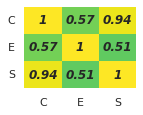

RESULTS
Kendall's W: 0.8741258741258742
Kendall's Tau:
Complexity / EffectiveComplexity : 0.5737985964123903 (0.010487005735214912)
Complexity / Sparseness : 0.9393939393939392 (3.2150205761316875e-07)
EffectiveComplexity / Sparseness : 0.5117663157191589 (0.02245053747688387)


In [74]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_complexity_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

### Randomization

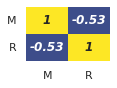

RESULTS
Kendall's W: 0.1756993006993007
Kendall's Tau:
Model Parameter Randomisation / Random Logit : -0.5343667144834019 (0.016141430453050783)


In [75]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_randomization_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(1.5,1))

## Robustness

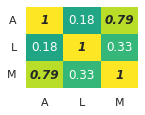

RESULTS
Kendall's W: 0.668997668997669
Kendall's Tau:
Avg-Sensitivity / Local Lipschitz Estimate : 0.1818181818181818 (0.459023957331249)
Avg-Sensitivity / Max-Sensitivity : 0.7878787878787877 (0.00010742344075677409)
Local Lipschitz Estimate / Max-Sensitivity : 0.3333333333333333 (0.15259045898802842)


In [76]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_robustness_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics with default baselines (i.e. black)

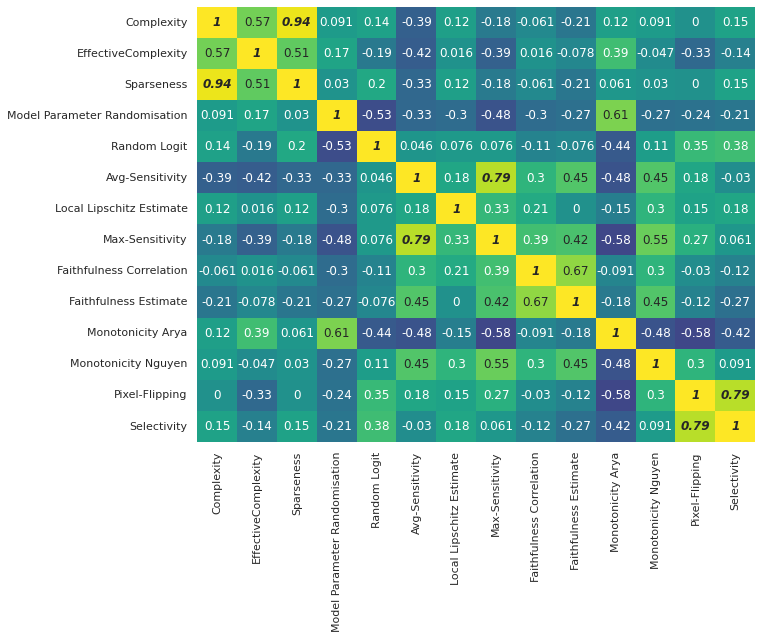

RESULTS
Kendall's W: 0.10302197802197802
Kendall's Tau:
Complexity / EffectiveComplexity : 0.5737985964123903 (0.010487005735214912)
Complexity / Sparseness : 0.9393939393939392 (3.2150205761316875e-07)
Complexity / Model Parameter Randomisation : 0.0909090909090909 (0.7373055246579552)
Complexity / Random Logit : 0.13740858372430334 (0.5361739338988774)
Complexity / Avg-Sensitivity : -0.39393939393939387 (0.0863171145983646)
Complexity / Local Lipschitz Estimate : 0.1212121212121212 (0.6383612539081289)
Complexity / Max-Sensitivity : -0.1818181818181818 (0.459023957331249)
Complexity / Faithfulness Correlation : -0.0606060606060606 (0.8405883696421891)
Complexity / Faithfulness Estimate : -0.2121212121212121 (0.38070480349126185)
Complexity / Monotonicity Arya : 0.1212121212121212 (0.6383612539081289)
Complexity / Monotonicity Nguyen : 0.0909090909090909 (0.7373055246579552)
Complexity / Pixel-Flipping : 0.0 (1.0534407108452248)
Complexity / Selectivity : 0.1515151515151515 (0.5452047

In [77]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_default_baselines_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False)

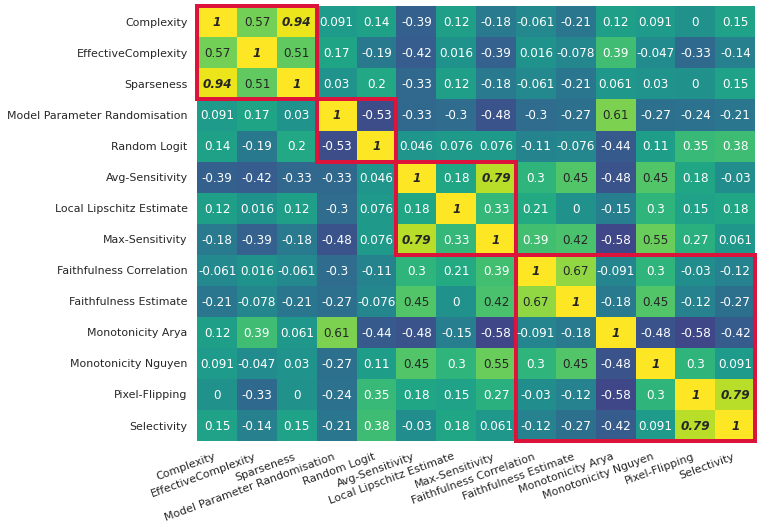

RESULTS
Kendall's W: 0.10302197802197802
Kendall's Tau:
Complexity / EffectiveComplexity : 0.5737985964123903 (0.010487005735214912)
Complexity / Sparseness : 0.9393939393939392 (3.2150205761316875e-07)
Complexity / Model Parameter Randomisation : 0.0909090909090909 (0.7373055246579552)
Complexity / Random Logit : 0.13740858372430334 (0.5361739338988774)
Complexity / Avg-Sensitivity : -0.39393939393939387 (0.0863171145983646)
Complexity / Local Lipschitz Estimate : 0.1212121212121212 (0.6383612539081289)
Complexity / Max-Sensitivity : -0.1818181818181818 (0.459023957331249)
Complexity / Faithfulness Correlation : -0.0606060606060606 (0.8405883696421891)
Complexity / Faithfulness Estimate : -0.2121212121212121 (0.38070480349126185)
Complexity / Monotonicity Arya : 0.1212121212121212 (0.6383612539081289)
Complexity / Monotonicity Nguyen : 0.0909090909090909 (0.7373055246579552)
Complexity / Pixel-Flipping : 0.0 (1.0534407108452248)
Complexity / Selectivity : 0.1515151515151515 (0.5452047

In [78]:
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, labels, labels, filename, fig_size=(10,8), half_rotate_x=True, subgroups=(3,2,3,6))

### All metrics with all baselines

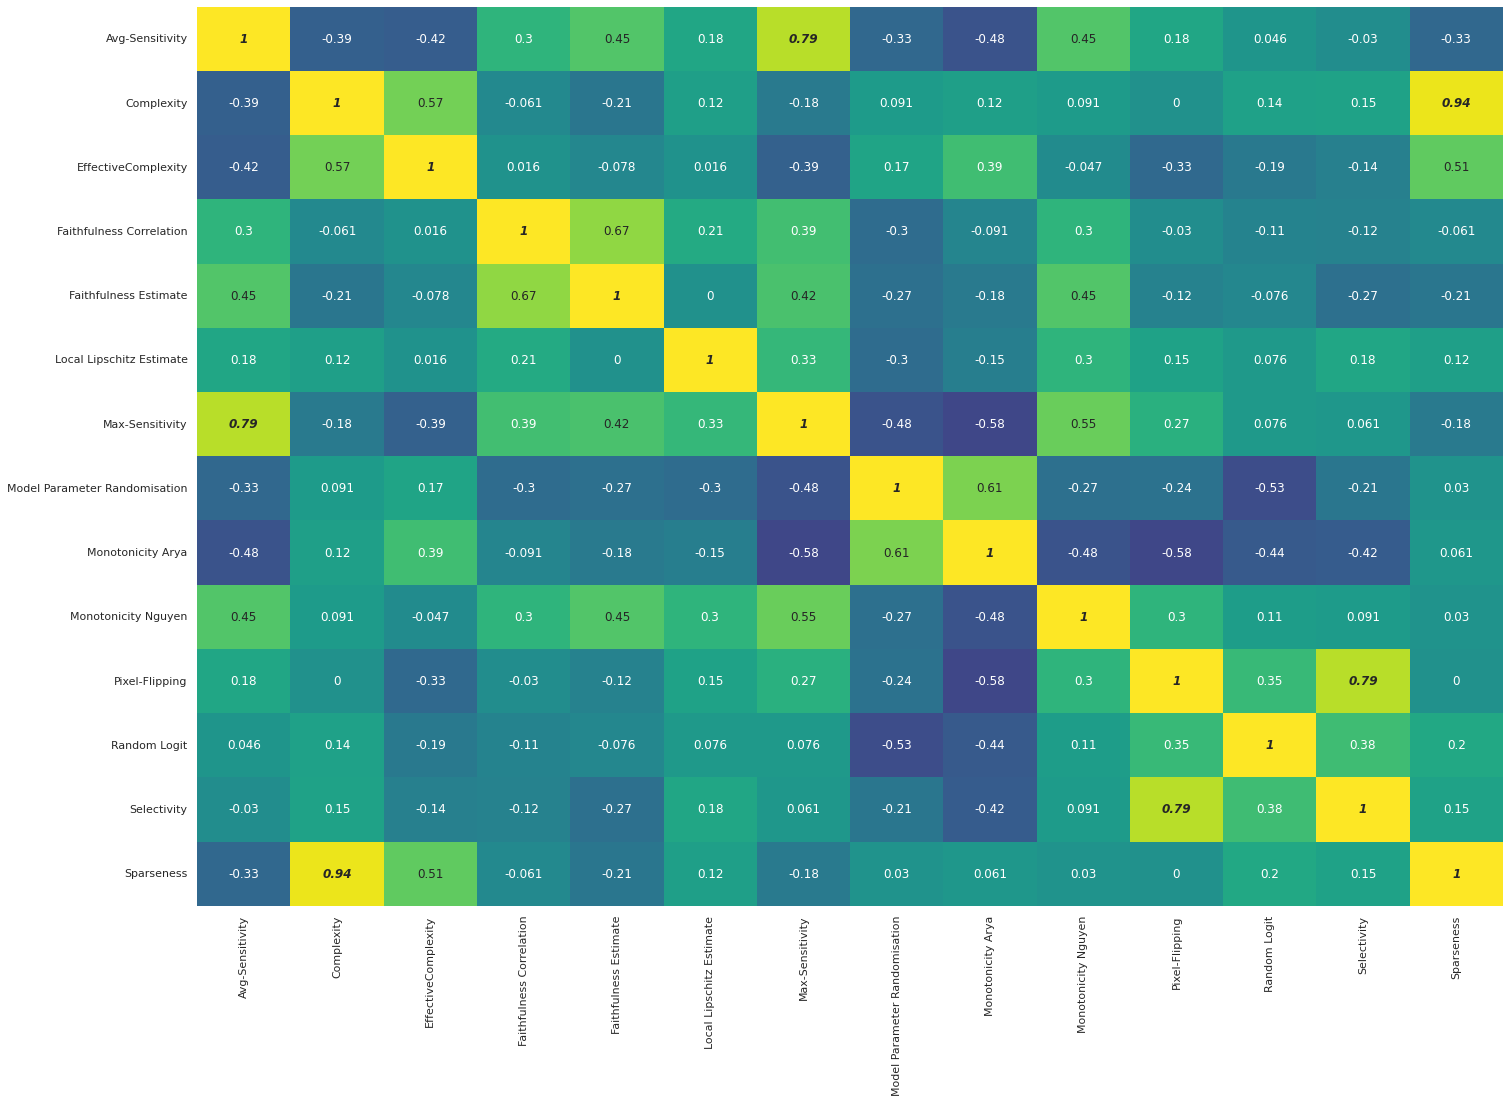

RESULTS
Kendall's W: 0.10302197802197802
Kendall's Tau:
Avg-Sensitivity / Complexity : -0.39393939393939387 (0.0863171145983646)
Avg-Sensitivity / EffectiveComplexity : -0.41871789467931186 (0.06181379399394178)
Avg-Sensitivity / Faithfulness Correlation : 0.303030303030303 (0.19694994338223504)
Avg-Sensitivity / Faithfulness Estimate : 0.4545454545454545 (0.04473689858238469)
Avg-Sensitivity / Local Lipschitz Estimate : 0.1818181818181818 (0.459023957331249)
Avg-Sensitivity / Max-Sensitivity : 0.7878787878787877 (0.00010742344075677409)
Avg-Sensitivity / Model Parameter Randomisation : -0.3333333333333333 (0.15259045898802842)
Avg-Sensitivity / Monotonicity Arya : -0.4848484848484848 (0.031050242838437284)
Avg-Sensitivity / Monotonicity Nguyen : 0.4545454545454545 (0.04473689858238469)
Avg-Sensitivity / Pixel-Flipping : 0.1818181818181818 (0.459023957331249)
Avg-Sensitivity / Random Logit : 0.04580286124143445 (0.8366323297132776)
Avg-Sensitivity / Selectivity : -0.0303030303030303 (0

In [79]:
selected_metrics = sorted(dico_ranks['cifar10']['resnet50'].keys())
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_all_baselines_resnet50_cifar10'
plot_corr_matrix_figure(dico_ranks['cifar10']['resnet50'], selected_metrics, selected_metrics, selected_metrics, filename, fig_size=(23.4,16.54), rotate_x=False)